# [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) for NLP

Import packages

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from time import gmtime, strftime
from pprint import pprint as pp
from collections import Counter
import multiprocessing as mp
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import nltk
from nltk.stem import WordNetLemmatizer
import os
import re
NUM_CLASSES=6
NUM_FC1 = 800
NUM_FC2 = 600
MAX_COMMENT_LENGTH = 1000
FEATUR_VECTOR_LENGTH = 1000
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
PROJ_NAME = "CNN_TOXIC"

ModuleNotFoundError: No module named 'tensorflow'

Print env stats

In [5]:
print(device_lib.list_local_devices())
print("CPUs:", mp.cpu_count())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4462979149109047118
]
CPUs: 56


Load data, stopwords and config

In [6]:
with open("/Users/abpwrs/NLP-DL/config.json", "rb") as f:
    config = json.load(f) # load config
data_dir = os.path.join(config["data_dir"],PROJ_NAME)
model_dir = os.path.join(config["model_dir"],PROJ_NAME)
with open(os.path.join(data_dir,"stopwords.txt"), "r") as f:
    stopwords = f.readlines() # load stopwords                              
stopwords = set([i.split()[0] for i in stopwords]) # remove new line characters (\n) from strings
df = pd.read_csv(os.path.join(data_dir, "train.csv"))

Colum names and basic description of data

['id',
 'comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']


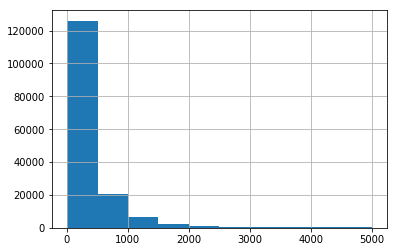

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,394.073221
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,590.720282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,435.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


In [35]:
# pp(list(df.columns))
# df['comment_length'] = df.comment_text.str.len()
# df['comment_length'].hist()
# plt.show()
# df.describe()

In [56]:
def adjust_class_balance(df: pd.DataFrame, interested_labels, thresh):
    dfs = {}
    null = df.copy()
    for name in interested_labels:
        dfs[name] = df.loc[(df[name] == 1)]
        null.drop(null[null[name]==1].index,axis=0,inplace=True)
        
    print("NULL:", 100*(len(null)/len(df)))
    for name, d in dfs.items():
        print("Initial percentage of DF for", name, "is", 100*(len(d)/len(df)))
    
    print("Each label will now have at least", thresh*100,"% of the origional df size")
    adjusted_df = null.sample(int(thresh*len(df))) # get a subsample of null cases
    

    for n, d in dfs.items():
        i=0
        for times in range(math.ceil((thresh/(len(d)/len(df))+1))):
            adjusted_df = adjusted_df.append(d)
            i+=1
        print(n,"upsampled",i,"times")
    return adjusted_df

df = adjust_class_balance(df, LABELS, 1/(len(LABELS)+1))

In [36]:
# CREDIT: https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_comment(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    return string.lower()

In [37]:
lemmatizer = WordNetLemmatizer()
# CODE TO GENERATE CLEANED COMMENTS
cleaned = [[lemmatizer.lemmatize(x) for x in nltk.word_tokenize(clean_comment(comment)) if x.isalpha() and not x in stopwords] for comment in df["comment_text"]]
np.save(os.path.join(data_dir, "cleaned.npy"), cleaned)
# CODE TO LOAD CLEANED COMMENTS FROM FILE
# cleaned = np.load(os.path.join(data_dir, "cleaned.npy"))

In [38]:
def bag_of_words(data:np.array):
    a = []
    for sent in data:
            for word in sent:
                a.append(word)
    bag = list(dict(Counter(a).most_common(FEATUR_VECTOR_LENGTH)).keys())
    
    vecs = []
    for sent in data:
        vec = []
        for word in bag:
            vec.append(int(word in sent))
        vecs.append(vec)
    return bag, vecs

In [39]:
bag, vecs = bag_of_words(cleaned)
vecs = np.array(vecs)
np.save(os.path.join(data_dir, "vectors.npy"), vecs)
with open(os.path.join(data_dir, "bag.txt"), 'w') as f:
    for word in bag:
        f.write(word+ "\n")
# vecs = np.load(os.path.join(data_dir, "vectors.npy")).astype(np.float32)

In [40]:
labels = np.array(df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]])

In [49]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=2, padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'))
model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=2, padding="same"))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=NUM_FC1, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(units=NUM_FC2, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=[tf.keras.metrics.mae,tf.keras.metrics.mse,tf.keras.metrics.categorical_crossentropy, tf.keras.metrics.categorical_accuracy])

In [50]:
x_train, x_test, y_train, y_test = train_test_split(vecs, labels, test_size=0.33)
x_train = x_train.reshape(x_train.shape[0], 1, FEATUR_VECTOR_LENGTH)
x_test = x_test.reshape(x_test.shape[0], 1, FEATUR_VECTOR_LENGTH)

(106912, 1000)


In [51]:
output_model_dir = os.path.join(model_dir,"uncorrected_"+strftime("%Y-%m-%d_%H:%M:%S", gmtime()))
if not os.path.isdir(output_model_dir):
    os.makedirs(output_model_dir)
checkpoint_path = os.path.join(output_model_dir,"cp-{epoch:04d}.ckpt")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1,
    # Save weights, every 5-epochs.
    period=2)


In [52]:
model.fit(x_train, y_train,
          batch_size=500,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [cp_callback])

Train on 106912 samples, validate on 52659 samples
Epoch 1/5
106912/106912 [==============================] - 4s 33us/step - loss: 0.3115 - mean_absolute_error: 0.3854 - mean_squared_error: 0.2484 - categorical_crossentropy: 0.3115 - categorical_accuracy: 0.9858 - val_loss: 0.3016 - val_mean_absolute_error: 0.3297 - val_mean_squared_error: 0.2207 - val_categorical_crossentropy: 0.3016 - val_categorical_accuracy: 0.9936
Epoch 2/5
106912/106912 [==============================] - 3s 29us/step - loss: 0.2918 - mean_absolute_error: 0.3114 - mean_squared_error: 0.2093 - categorical_crossentropy: 0.2918 - categorical_accuracy: 0.9929 - val_loss: 0.2949 - val_mean_absolute_error: 0.3041 - val_mean_squared_error: 0.2047 - val_categorical_crossentropy: 0.2949 - val_categorical_accuracy: 0.9894

Epoch 00002: saving model to /Users/abpwrs/NLP-DL/model/uncorrected_2018-11-03_20:02:22/cp-0002.ckpt
Epoch 3/5
106912/106912 [==============================] - 3s 28us/step - loss: 0.2856 - mean_absolute_

In [55]:
score = model.evaluate(x_test, y_test, verbose=1)
pp(score)

52659/52659 [==============================] - 3s 49us/step
[0.2899430568366193,
 0.2542817351034087,
 0.1761526752725759,
 0.2899430568366193,
 0.98254809245176]


In [16]:
temp = vecs.reshape(vecs.shape[0], 1, FEATUR_VECTOR_LENGTH)
result = {}
for index in range(NUM_CLASSES):
    temp_dict = {}
    y_pred = model.predict(temp).astype(np.int32)
    true_pos = true_neg = 0
    pos = neg = 0
    for p in range(len(y_pred)):
        if labels[p][index] == 1:
            pos += 1
            if y_pred[p][index] == 1:
                true_pos += 1
        else:
            neg += 1
            if y_pred[p][index] == 0:
                true_neg += 1
        
    temp_dict["TP"] = true_pos
    temp_dict["TN"] = true_neg
    temp_dict["P"] = pos
    temp_dict["N"] = neg
    result[index] = temp_dict

In [9]:
pp(result)
with open(os.path.join(data_dir, "confusion.pkl"), "wb") as f:
    json.dump(result,f)

NameError: name 'result' is not defined